<a href="https://colab.research.google.com/github/Narissarach/Project_eye/blob/main/2022project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import tensorflow as tf
import PIL
import time
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pickle as p
import plotly
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
import plotly.graph_objs as go
from tensorflow import keras
from tensorflow.keras.models import Sequential

## เตรียมชุดของข้อมูล

In [40]:
from google.colab import drive # เชื่อม drive ของเรา ถ้าเชื่อมสำเร็จจะขึ้นคำว่า Mounted at /content/drive 
drive.mount('/content/drive')
path = '/content/drive/My Drive/2022Project/dataeye'  # ชี้ว่า data เราอยู่โฟล์เดอร์ไหน

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
import pathlib
data_dir = pathlib.Path('/content/drive/My Drive/2022Project/dataeye')

In [42]:
batch_size = 64   # กำหนดขนาดของแต่ละการอ่านข้อมูล
img_height = 224  # ความสูงของรูปภาพแต่ละรูป
img_width = 224   # ความกว้างของรูปภาพแต่ละรูป

## Train

In [43]:
train = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
validation_split=0.1, # s แบ่งข้อมูล เพื่อ training 90% และ validation 10%
subset="training",
seed=123,
image_size=(img_height, img_width),
batch_size=batch_size)
val = tf.keras.preprocessing.image_dataset_from_directory(
data_dir,
validation_split=0.1,
subset="validation",
seed=123,
image_size=(img_height, img_width),
batch_size=batch_size)

Found 16556 files belonging to 3 classes.
Using 14901 files for training.
Found 16556 files belonging to 3 classes.
Using 1655 files for validation.


In [44]:
class_names = train.class_names
print(class_names)

['Crop CSC', 'Crop PCV', 'Crop VKH']


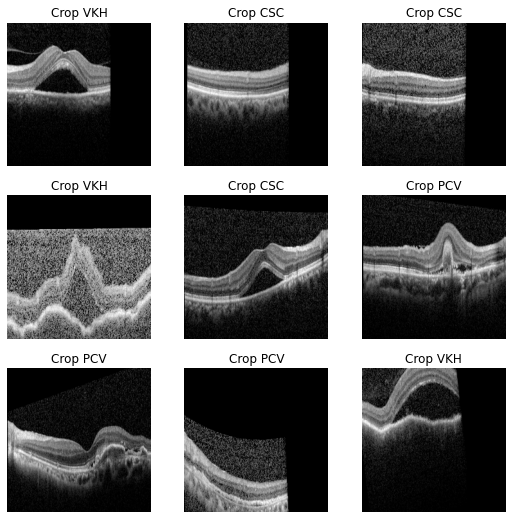

In [45]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 9)) #ขนาด
for images, labels in train.take(1):
  for i in range(9): #มี 9 รูป
    ax = plt.subplot(3, 3, i + 1) #แถวละ 3
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [46]:
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 224, 224, 3)
(64,)


## Normalization

In [70]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1. / 255)
normalized_ds = train.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.99974996


## Model

In [48]:
num_classes = 3
epochs=30   # จำนวนครั้งที่เราจะ Train

In [49]:
model = Sequential([
layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
layers.Conv2D(16, 3, padding='same', activation='relu'),
layers.MaxPooling2D(),
layers.Conv2D(32, 3, padding='same', activation='relu'),
layers.MaxPooling2D(),
layers.Conv2D(64, 3, padding='same', activation='relu'),
layers.MaxPooling2D(),
layers.Flatten(),
layers.Dense(128, activation='relu'),
layers.Dense(num_classes)
])

In [50]:
model.compile(optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 64)       

In [51]:
his = model.fit(
train,
validation_data=val,
epochs=epochs
)

Epoch 1/30
233/233 [==============================] - 123s 511ms/step - loss: 0.8380 - accuracy: 0.6005 - val_loss: 0.5165 - val_accuracy: 0.7873
Epoch 2/30
233/233 [==============================] - 125s 522ms/step - loss: 0.4075 - accuracy: 0.8404 - val_loss: 0.2914 - val_accuracy: 0.8924
Epoch 3/30
233/233 [==============================] - 125s 519ms/step - loss: 0.1730 - accuracy: 0.9379 - val_loss: 0.3111 - val_accuracy: 0.8924
Epoch 4/30
233/233 [==============================] - 126s 526ms/step - loss: 0.0766 - accuracy: 0.9748 - val_loss: 0.2081 - val_accuracy: 0.9245
Epoch 5/30
233/233 [==============================] - 125s 520ms/step - loss: 0.0389 - accuracy: 0.9873 - val_loss: 0.1985 - val_accuracy: 0.9444
Epoch 6/30
233/233 [==============================] - 127s 529ms/step - loss: 0.0208 - accuracy: 0.9939 - val_loss: 0.2429 - val_accuracy: 0.9335
Epoch 7/30
233/233 [==============================] - 125s 520ms/step - loss: 0.0229 - accuracy: 0.9915 - val_loss: 0.2127 -

## Save Model

In [52]:
with open('history_model', 'wb') as file:
   p.dump(his.history, file)

filepath='model1.h5'
model.save(filepath)
filepath_model = 'model1.json'
filepath_weights = 'weights_model.h5'
model_json = model.to_json()
with open(filepath_model, "w") as json_file:
   json_file.write(model_json)

model.save_weights('weights_model.h5')
print("Saved model to disk")

Saved model to disk


## Load Model

In [53]:
with open('history_model', 'rb') as file:
   his = p.load(file)

h1 = go.Scatter(y=his['loss'],
mode="lines", line=dict(
width=2,
color='blue'),
name="loss"
)
h2 = go.Scatter(y=his['val_loss'],
mode="lines", line=dict(
width=2,
color='red'),
name="val_loss"
)

data = [h1,h2]
layout1 = go.Layout(title='Loss',
xaxis=dict(title='epochs'),
yaxis=dict(title=' '))
fig1 = go.Figure(data, layout=layout1)
plotly.offline.iplot(fig1, filename="testMNIST")
predict_model = load_model(filepath)
predict_model.summary()
with open(filepath_model, 'r') as f:
   loaded_model_json = f.read()
predict_model = model_from_json(loaded_model_json)
predict_model.load_weights(filepath_weights)
print("Loaded model from disk")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 64)       

## Prediction

1/1 [==============================] - 0s 314ms/step
Crop CSC tf.Tensor(1.0, shape=(), dtype=float32) Crop PCV tf.Tensor(1.6077485e-22, shape=(), dtype=float32) Crop VKH tf.Tensor(1.0517816e-19, shape=(), dtype=float32)


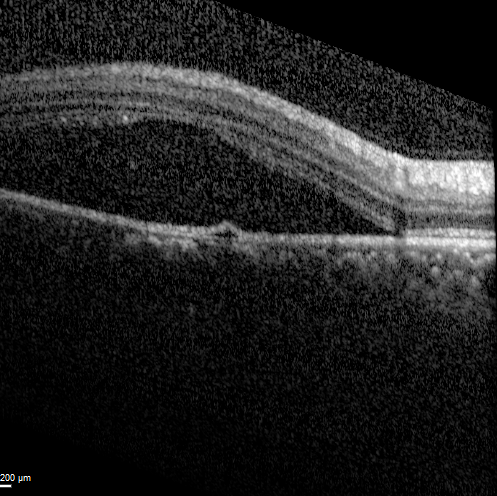

AI Crop CSC มีความมั่นใจ 100.00%.


In [55]:
import requests
from IPython.display import Image
from io import BytesIO
test_path = ('/content/drive/My Drive/testeye/testc.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("Crop CSC",score[0],"Crop PCV",score[1],"Crop VKH",score[2])
display(Image(filename=test_path,width=180, height=180))
if score[0]==np.max(score) :
   fruit = "Crop CSC"
elif score[1]==np.max(score) :
   fruit = "Crop PCV"
elif score[2]==np.max(score) :
   fruit = "Crop VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(fruit, 100 * np.max(score))
)

1/1 [==============================] - 0s 18ms/step
Crop CSC tf.Tensor(3.93765e-12, shape=(), dtype=float32) Crop PCV tf.Tensor(1.0, shape=(), dtype=float32) Crop VKH tf.Tensor(9.731084e-16, shape=(), dtype=float32)


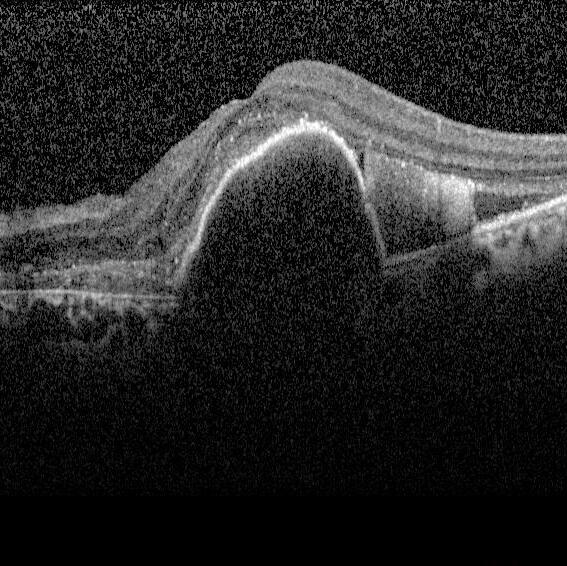

AI Crop PCV มีความมั่นใจ 100.00%.


In [56]:
test_path = ('/content/drive/My Drive/testeye/testp.jpg')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("Crop CSC",score[0],"Crop PCV",score[1],"Crop VKH",score[2])
display(Image(filename=test_path,width=180, height=180))
if score[0]==np.max(score) :
   fruit = "Crop CSC"
elif score[1]==np.max(score) :
   fruit = "Crop PCV"
elif score[2]==np.max(score) :
   fruit = "Crop VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(fruit, 100 * np.max(score))
)

1/1 [==============================] - 0s 15ms/step
Crop CSC tf.Tensor(0.9999964, shape=(), dtype=float32) Crop PCV tf.Tensor(1.013301e-17, shape=(), dtype=float32) Crop VKH tf.Tensor(3.5404425e-06, shape=(), dtype=float32)


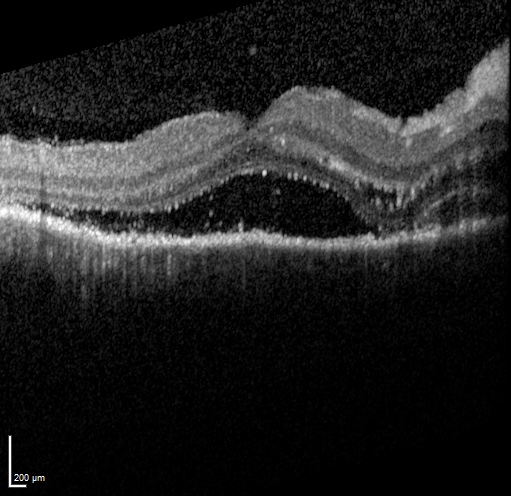

AI Crop CSC มีความมั่นใจ 100.00%.


In [57]:
test_path = ('/content/drive/My Drive/testeye/testv.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("Crop CSC",score[0],"Crop PCV",score[1],"Crop VKH",score[2])
display(Image(filename=test_path,width=180, height=180))
if score[0]==np.max(score) :
   fruit = "Crop CSC"
elif score[1]==np.max(score) :
   fruit = "Crop PCV"
elif score[2]==np.max(score) :
   fruit = "Crop VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(fruit, 100 * np.max(score))
)

# Test

In [58]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt

In [67]:
# dimensions of our images
img_width, img_height = 224, 224

# Load the model we save
model = load_model('model1.h5')

['c1.png', 'c2.png', 'p1.png', 'p3.png', 'p4.png', 'v3.png', 'p2.png', 'v1.png', 'v2.png', 'v4.png', 'c4.png', 'c3.png']
c1.png


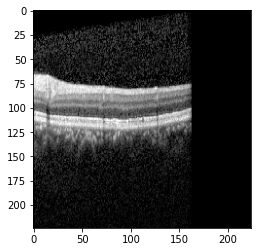

1/1 [==============================] - 0s 16ms/step
[[-3.7034166 -2.190113   5.0229917]]
Crop VKH , 5.02
c1.png: Crop VKH
--------------------------------------------
c2.png


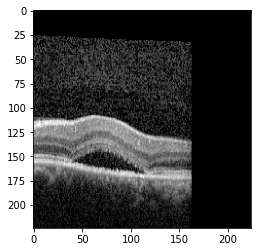

1/1 [==============================] - 0s 18ms/step
[[-3.7026293 -2.1995246  5.0322404]]
Crop VKH , 5.03
c2.png: Crop VKH
--------------------------------------------
p1.png


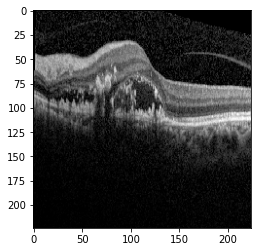

1/1 [==============================] - 0s 18ms/step
[[-3.7044547 -2.1901383  5.0222344]]
Crop VKH , 5.02
p1.png: Crop VKH
--------------------------------------------
p3.png


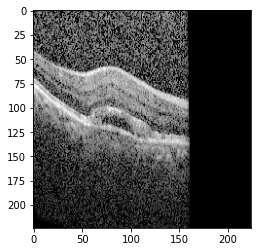

1/1 [==============================] - 0s 18ms/step
[[-3.7108095 -2.2009947  5.0392065]]
Crop VKH , 5.04
p3.png: Crop VKH
--------------------------------------------
p4.png


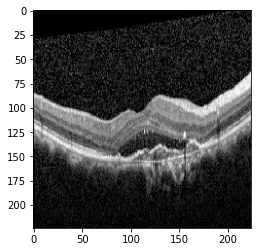

1/1 [==============================] - 0s 16ms/step
[[-3.7009766 -2.193013   5.024351 ]]
Crop VKH , 5.02
p4.png: Crop VKH
--------------------------------------------
v3.png


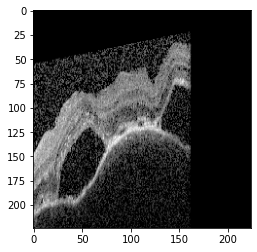

1/1 [==============================] - 0s 19ms/step
[[-3.7018433 -2.19668    5.0257883]]
Crop VKH , 5.03
v3.png: Crop VKH
--------------------------------------------
p2.png


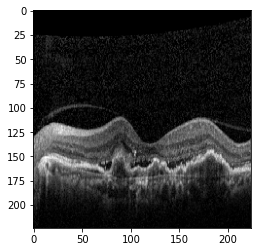

1/1 [==============================] - 0s 17ms/step
[[-3.701899  -2.1952095  5.026879 ]]
Crop VKH , 5.03
p2.png: Crop VKH
--------------------------------------------
v1.png


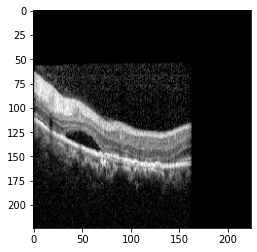

1/1 [==============================] - 0s 18ms/step
[[-3.7020118 -2.1979573  5.0280046]]
Crop VKH , 5.03
v1.png: Crop VKH
--------------------------------------------
v2.png


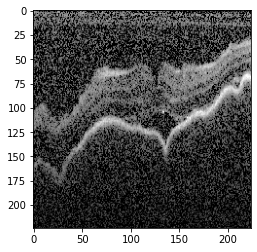

1/1 [==============================] - 0s 17ms/step
[[-3.721375  -2.1968641  5.043952 ]]
Crop VKH , 5.04
v2.png: Crop VKH
--------------------------------------------
v4.png


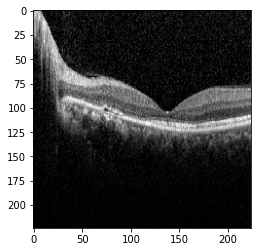

1/1 [==============================] - 0s 18ms/step
[[-3.7023323 -2.191387   5.023078 ]]
Crop VKH , 5.02
v4.png: Crop VKH
--------------------------------------------
c4.png


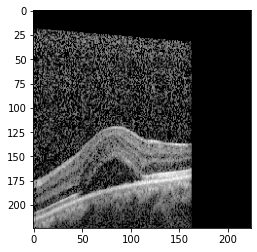

1/1 [==============================] - 0s 19ms/step
[[-3.7052026 -2.211263   5.037447 ]]
Crop VKH , 5.04
c4.png: Crop VKH
--------------------------------------------
c3.png


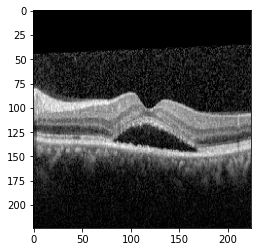

1/1 [==============================] - 0s 17ms/step
[[-3.6996908 -2.194358   5.022149 ]]
Crop VKH , 5.02
c3.png: Crop VKH
--------------------------------------------


In [86]:
mypath = ('/content/drive/My Drive/2022Project/testdataeye/')
# Label_calss = {'Crop CSC','Crop PCV','Crop VKH'}
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
print(onlyfiles)

# Predicting images
for file in onlyfiles:
  print(file)
  img = image.load_img(mypath+file, target_size=(img_width, img_height))

  imgplot = plt.imshow(img)
  plt.show()

  x = image.img_to_array(img)
  x /= 255.0
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images)
  # classes = model.predict_classes(images)
  print(classes)
  #classes = classes[0][0]

  if np.argmax(classes) == 0:
    print("%s , %.2f" %  ("Crop CSC", (classes[0][np.argmax(classes)]*100)))
    print(file + ": " + 'Crop CSC')
  
  elif np.argmax(classes) == 1:
    print("%s , %.2f" %  ("Crop PCV", (classes[0][np.argmax(classes)]*100)))
    print(file + ": " + 'Crop PCV')
  
  else :
    print("%s , %.2f" %  ("Crop VKH", (classes[0][np.argmax(classes)]*100)))
    print(file + ": " + 'Crop VKH')
  

  print('--------------------------------------------')

# Confusion Matrix